# Distributed LoRA with HuggingFace SageMaker-SDK
### Binary Classification with `Trainer` and `imdb` dataset

In [ ]:
# ST NOTES:

# OBJECTIVE:
# To implement LoRA training in distributed SageMaker session with PyTorch and PEFT library

# BASE SCRIPTs (No LoRA) from: https://huggingface.co/docs/sagemaker/train 
#                              https://github.com/huggingface/notebooks/blob/main/sagemaker/01_getting_started_pytorch/sagemaker-notebook.ipynb
# LoRA uses PEFT library and the implementation is based on the Coursera's Generative AI Certificate
# LoRA is a form of transfer learinig where we take pre-traind fundational model and fine-tune it to the specifc task/data
# LoRA freezes the parameters of the fundational model and adds new weight matrices to the model that are trainable.
# the new weight matrices capture the specificity of the new task/data and apply it on top if the broad language understaning of the fundational model
# the new weight metrices are represeted by lower dimensional decompositions of those matrices.
# 
# STEPs & FINDINGs:
#    1. Prepare SM Environment
#    2. Prepare the data file and load it to S3
#    3. Modify .py file to add the PEFT/LoRA functionality
#       - Add LoRA specific lines of code to the HuggingFace SageMaker SDK example notebook and .py file
#.      - Reduces the trainable parameter set to 2.5% of the original
#    4. Test on single GPU instance 'ml.p3.2xlarge' with PyTorch
#       - Works without any additional modifications.
#    5. Test in DDP mode of the SM-SDK with PyTorch
#       - Above implementation results in Error: "Model includes parameters that are not included in the calculation of a loss"
#       - Solution based on: https://github.com/pytorch/pytorch/issues/43259
#       - Issue: SM DDP does not include some of the layers in the LOSS calculations
#.      - Solution: specify which layers should have gradients calculated and which do not
#                   - while this works, this solution needs to be analyzed further as 
#                     there is possibility that such modification alters the expected behaviour of the PEFT model
#                     and/or we might freeze some layers that PEFT/LoRA sets as trainable
#     6. Test on DMP
#.       - not performed!
#        - the objective PEFT/LoRA is to reduce the size of the trainiable part model to enable it 
#          to be trained with less hardware (GPUs, Memory, Instances,...)
#          and current implementation reduces trainaible parameters to 2.5% of the full model count
#.         thus I will workout LoRA with DMP when the need for it materializes.


1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Introduction

Welcome to our end-to-end binary Text-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer on binary text classification. In particular, the pre-trained model will be fine-tuned using the `imdb` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

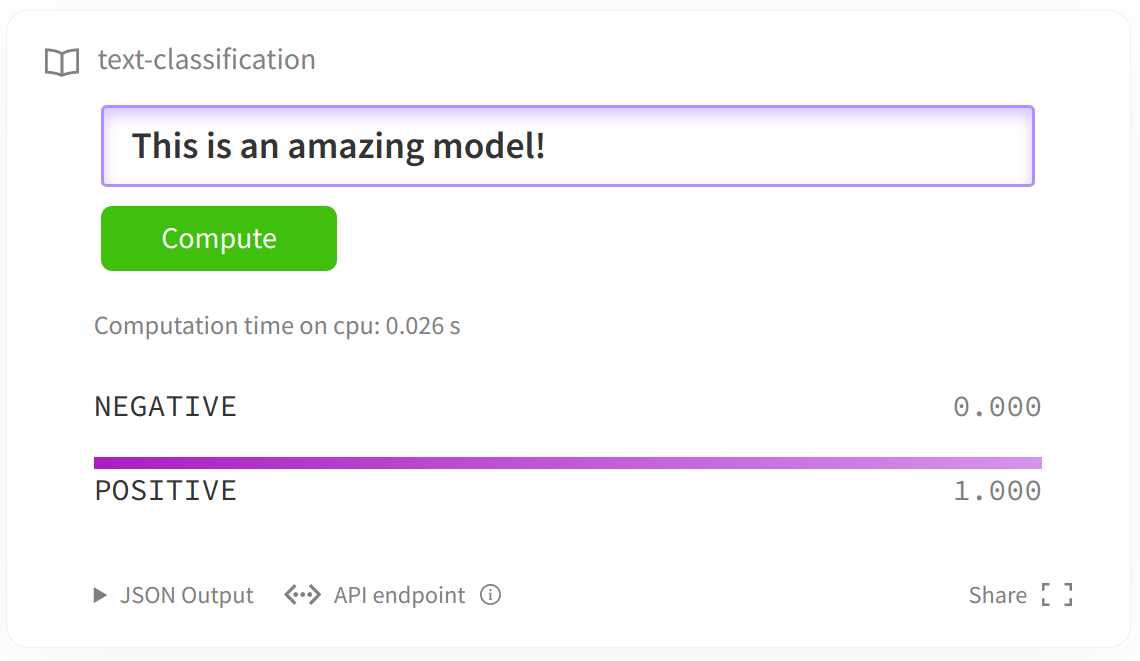

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [2]:
#!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" "torch" --upgrade
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade

  Using cached sagemaker-2.173.0-py2.py3-none-any.whl
  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Using cached datasets-2.10.1-py3-none-any.whl (469 kB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Using cached tokenizers-0.13.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached xxhash-3.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (213 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.42.1
    Uninstalling tqdm-4.42.1:
      Successfully uninstalled tqdm-4.42.1
  Attempting uninstall: packaging
    Fou

## Development environment 

In [3]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [4]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::578864530451:role/service-role/AmazonSageMaker-ExecutionRole-20210306T201609
sagemaker bucket: sagemaker-us-east-1-578864530451
sagemaker session region: us-east-1


# Preprocessing

We are using the `datasets` library to download and preprocess the `imdb` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [imdb](http://ai.stanford.edu/~amaas/data/sentiment/) dataset consists of 25000 training and 25000 testing highly polar movie reviews.

## Tokenization 

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'imdb'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/imdb'

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [7]:
# load dataset
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d16bb3b5a60af224.arrow


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [6]:
# PATHs are also needed for training; SAVING files happens only once when data is generated initially

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
#train_dataset.save_to_disk(training_input_path)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
#test_dataset.save_to_disk(test_input_path)


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train-LORA.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [7]:
!pygmentize ./scripts/train.py

Error: cannot read infile: [Errno 2] No such file or directory: './scripts/train.py'


## Creating an Estimator and start a training job

In [8]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased',
                 "eval_batch_size": 256 # InExample: 64
                 }

In [11]:
# TEST on single instance as distibuted training might (and it does) intorduce its own issue

huggingface_estimator = HuggingFace(entry_point='train-LORA.py',
                            source_dir='./',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.26',
                            pytorch_version='1.13',
                            py_version='py39',
                            hyperparameters = hyperparameters)

In [13]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2023-07-25-11-40-33-719


2023-07-25 11:41:30 Starting - Starting the training job...
2023-07-25 11:41:57 Starting - Preparing the instances for training.........
2023-07-25 11:43:10 Downloading - Downloading input data...
2023-07-25 11:43:35 Training - Downloading the training image.....................
2023-07-25 11:47:21 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-25 11:47:39,602 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-25 11:47:39,621 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-25 11:47:39,633 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-25 11:47:39,636 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-25 11:47:47,842 sagemaker-training-toolkit INFO     No Neurons detect

UnexpectedStatusException: Error for Training job huggingface-pytorch-training-2023-07-25-11-40-33-719: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage "│ ❱  584 │   │   raise RuntimeError(                                           │
 │    585 │   │   │   "Default process group has not been initialized, "        │
 │    586 │   │   │   "please make sure to call init_process_group."            │
 │    587 │   │   )                                                             │
 ╰──────────────────────────────────────────────────────────────────────────────╯
 RuntimeError: Default process group has not been initialized, please make sure
 to call init_process_group."
Command "/opt/conda/bin/python3.9 train-LORA.py --epochs 1 --eval_batch_size 256 --model_name distilbert-base-uncased --train_batch_size 32", exit code: 1

## Deploying the endpoint - NOT PART OF THE TEST

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [12]:
predictor = huggingface_estimator.deploy(1, "ml.g4dn.xlarge")

INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2023-07-24-16-26-46-568
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2023-07-24-16-26-46-568
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2023-07-24-16-26-46-568


----------!

Then, we use the returned predictor object to call the endpoint.

In [13]:
sentiment_input= {"inputs":"I love using the new Inference DLC."}

predictor.predict(sentiment_input)

[{'label': 'LABEL_1', 'score': 0.9107698798179626}]

Finally, we delete the endpoint again.

In [14]:
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: huggingface-pytorch-training-2023-07-24-16-26-46-568
INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2023-07-24-16-26-46-568
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2023-07-24-16-26-46-568


# Extras - NOT PART OF THE TEST

### Estimator Parameters

In [15]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



container image used for training job: 
None

s3 uri where the trained model is located: 
s3://sagemaker-us-east-1-578864530451/huggingface-pytorch-training-2023-07-24-16-10-46-427/output/model.tar.gz

latest training job name for this estimator: 
huggingface-pytorch-training-2023-07-24-16-10-46-427



In [16]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

2023-07-24 16:25:39 Starting - Preparing the instances for training
2023-07-24 16:25:39 Downloading - Downloading input data
2023-07-24 16:25:39 Training - Training image download completed. Training in progress.
2023-07-24 16:25:39 Uploading - Uploading generated training model
2023-07-24 16:25:39 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-24 16:16:26,837 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-24 16:16:26,857 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-24 16:16:26,870 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-24 16:16:26,873 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-24 16:16:27,210 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)

### Attach to old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [ ]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name=''

In [ ]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data

In [18]:
from sagemaker.s3 import S3Downloader

S3Downloader.download(
    s3_uri=huggingface_estimator.model_data, # S3 URI where the trained model is located
    local_path='.',                          # local path where *.targ.gz is saved
    sagemaker_session=sess                   # SageMaker session used for training the model
)

['./model.tar.gz']

In [32]:
#####################################################################
############################# MAIN TEST #############################
#####################################################################

#####################################################################
##################### DATA DISTRIBUTED WITH LORA ####################
#####################################################################

from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased',
                 "eval_batch_size": 256 # InExample: 64
                 }

training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'

# configuration for running training on smdistributed data parallel
distribution = {'smdistributed':{'dataparallel':{'enabled': True,
                                                "custom_mpi_options": "-verbose -mca distributed-backend nccl -mca ddp-backend no_c10d"}}}
#                'mpi': {"enabled" : True,            # Required
#                        "processes_per_host" : 8,    # Required
#                        "custom_mpi_options" : "-distributed-backend 'nccl' --ddp-backend 'no_c10d'"}}

huggingface_estimator_DDP = HuggingFace(entry_point='train-LORA.py',
                            source_dir='./',
                            instance_type='ml.p3.16xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.26.0', # InExample: '4.26' with Error about the name
                            pytorch_version='1.13.1', # InExample: '1.13' with Error about the version
                            py_version='py39',
                            hyperparameters = hyperparameters,
                            distribution = distribution)

# starting the train job with our uploaded datasets as input
huggingface_estimator_DDP.fit({'train': training_input_path, 'test': test_input_path})

# TRAIN EXEC TIME 55

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2023-07-25-15-39-26-321


2023-07-25 15:40:21 Starting - Starting the training job.........
2023-07-25 15:41:28 Starting - Preparing the instances for training......
2023-07-25 15:42:44 Downloading - Downloading input data...
2023-07-25 15:43:06 Training - Downloading the training image...............
2023-07-25 15:45:47 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-25 15:46:13,077 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-25 15:46:13,142 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-25 15:46:13,155 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-25 15:46:13,158 sagemaker_pytorch_container.training INFO     Invoking SMDataParallel
2023-07-25 15:46:13,158 sagemaker_pytorch_container.training INFO     Invoking user tr

UnexpectedStatusException: Error for Training job huggingface-pytorch-training-2023-07-25-15-39-26-321: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage "RuntimeError: Expected to have finished reduction in the prior iteration before starting a new one. This error indicates that your module has parameters that were not used in producing loss. You can enable unused parameter detection by passing the keyword argument `find_unused_parameters=True` to `torch.nn.parallel.DistributedDataParallel`, and by
 making sure all `forward` function outputs participate in calculating loss.
 If you already have done the above, then the distributed data parallel module wasn't able to locate the output tensors in the return value of your module's `forward` function. Please include the loss function and the structure of the return value of `forward` of your module when reporting this issue (e.g. list, dict, iterable).
 Parameters which did not receive grad for rank 7: base_model.model.classifier.original_module.bias, base_model.model.classifier.original_module.weight, base_model.model.pre_classifier.original_module.

In [ ]:
#####################################################################
############################## TBC... ###############################
#####################################################################

#####################################################################
################# MODEL PARALLEL (LoRA NOT TESTED) ##################
#####################################################################

# configuration for running training on smdistributed model parallel
mpi_options = {"enabled" : True,
               "processes_per_host" : 8}

#""" # InExemple: -- but I had to change instance type and it results in GPU MEM ERROR

smp_options = {"enabled":True,
               "parameters": {"microbatches": 2, # InExample: 4 but changed to address the memory error
                              "placement_strategy": "spread",
                              "pipeline": "interleaved",
                              "optimize": "speed",
                              "partitions": 4, # InExample: 4 but changed to address the memory error
                              "ddp": True,}}
#"""

"""
# BABSED ON SM DMP explorations
# BUT ERROR: TypeError: SMTrainingCompilerConfigurationError() takes no keyword arguments
# and that is nowhere used in the code?!!??!!?
# can be another memory error but this needs investigation

smp_options = {"enabled": True,
               "parameters": {"partitions": 1, # Got an Error '"partitions" is a required parameter'!!!; controls pipeline_parallel_degree
                               "ddp": True, # PyTorch Specifc -- allows mix data+model parallel
                               "sharded_data_parallel_degree": 8,  # InExample: 32
                               "delayed_parameter_initialization": True,
                               "microbatches": 4, # DEFAULT: 1; TEST 4
                               "horovod": False, # DEFAULT: False; TEST True   ---- ValueError: 'ddp' and 'horovod' cannot be simultaneously enabled.
                               "ddp": True, # DEFAULT: False; TEST True   ---- ValueError: 'ddp' and 'horovod' cannot be simultaneously enabled.
                               "tensor_parallel_degree": 1, # DEFAULT: 1; TEST 2, ???
                               "fp16": False, # DEFAULT: False; TEST True
                               "fp16_params": False, # DEFAULT: False; TEST True --- DEPReciated
                               "bf16": True, # DEFAULT: False; TEST True
                               "offload_activations": True, # DEFAULT: False; TEST True
                               "shard_optimizer_state": False, # DEFAULT: False; TEST True
                               "activation_loading_horizon": 1, # DEFAULT: 4; TEST 1, ???  
                               "placement_strategy": "cluster" # DEFAULT: "cluster" ("DPT"); TEST "spread" ("TPD"), permutations of "D,P,T"
                              },}
"""

distribution={"smdistributed": {"modelparallel": smp_options},
              "mpi": mpi_options}

 # create the Estimator
huggingface_estimator_DMP = HuggingFace(entry_point='train-LORA.py',
                                    source_dir='./',
                                    instance_type='ml.p3.16xlarge',
                                    instance_count=1,
                                    role=role,
                                    transformers_version='4.26.0',
                                    pytorch_version='1.13.1',
                                    py_version='py39',
                                    hyperparameters = hyperparameters,
                                    distribution = distribution)

# starting the train job with our uploaded datasets as input
huggingface_estimator_DMP.fit({'train': training_input_path, 'test': test_input_path})